In [11]:

'''
Author: Damiano Pasquini
email: damiano23@ru.is
'''

# imports and configs
import os
import pandas as pd
import numpy as np
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from seaborn import heatmap

path = './dataset' # Path to the dataset
classifiers = [MultinomialNB(), KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), GradientBoostingClassifier()] # Classifiers to use

In [12]:
def read_data(path):
    """
    Reads the data from the csv file and returns a pandas dataframe
    :param path: path to the csv file
    :return: pandas dataframe
    """
    with open(path+"/api_trace.csv", 'r') as data_file:
        data = [str(line.split(',')) for line in data_file]
    with open(path+"/apt_trace_labels.txt", 'r') as label_file:
        labels = [line for line in label_file]
    return pd.DataFrame({'traces':data,'labels':labels})

In [13]:
def preprocess(df):
    """
    Preprocess the dataframe and returns the X and y for the training and test set
    :param df: pandas dataframe
    :return: X_train, X_test, y_train, y_test
    """
    df.drop_duplicates(subset=['traces'], inplace=True)
    df.replace([np.inf], np.finfo(np.float32).max, inplace=True) # Replace inf values with max of float 32
    df.replace([-np.inf], -np.finfo(np.float32).min, inplace=True) # Replace inf values with min value of float 32
    df.fillna(0, inplace=True) # Replace all NaN values with 0
    X_train, X_test, y_train, y_test = train_test_split(df['traces'], df['labels'], test_size=0.3, random_state=42)
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.toarray())
    X_test = scaler.transform(X_test.toarray())
    return X_train, X_test, y_train, y_test

In [14]:
def train_classifier(X_train, X_test, y_train, y_test, classifier = MultinomialNB()):
    """
    Trains the classifier and prints the heatmap of the confusion matrix
    :param X_train: training set
    :param X_test: test set
    :param y_train: training labels
    :param y_test: test labels
    :param classifier: classifier to use
    :return: None
    """
    cf = classifier
    if classifier == LogisticRegression():
        cf = LogisticRegression(max_iter=1000)
    elif classifier == SVC():
        cf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    elif classifier == GradientBoostingClassifier():
        cf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
    cf.fit(X_train, y_train)
    y_pred = cf.predict(X_test)
    matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    heatmap(matrix, annot=True)
    f1score = f1_score(y_test, y_pred, average='weighted')
    print('F1 Score: '+str(f1score))
    plt.show()
    return

In [15]:
print('Preprocessing...')
X_train, X_test, y_train, y_test = preprocess(read_data(path))

Preprocessing...


Training classifier:  <class 'sklearn.naive_bayes.MultinomialNB'>
F1 Score: 0.30399494071901517


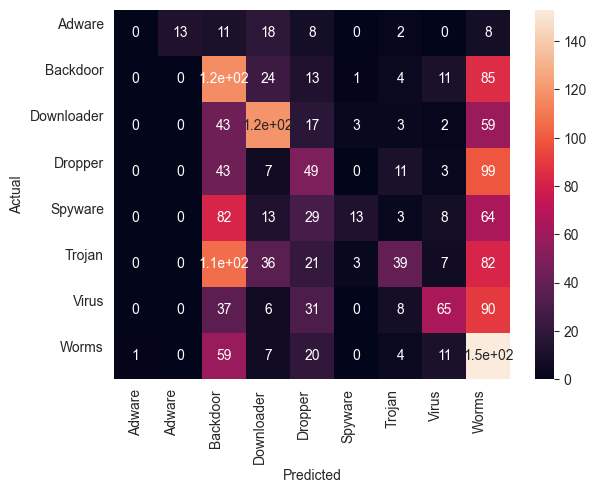

Training classifier:  <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
F1 Score: 0.41395390281195277


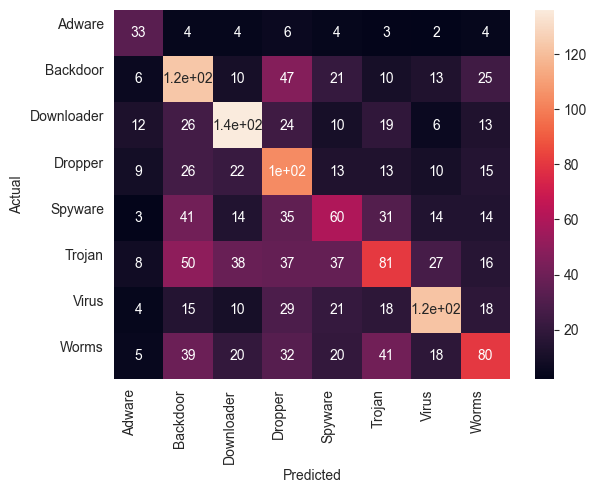

Training classifier:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
F1 Score: 0.2939364863894123


C:\Users\pasqu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


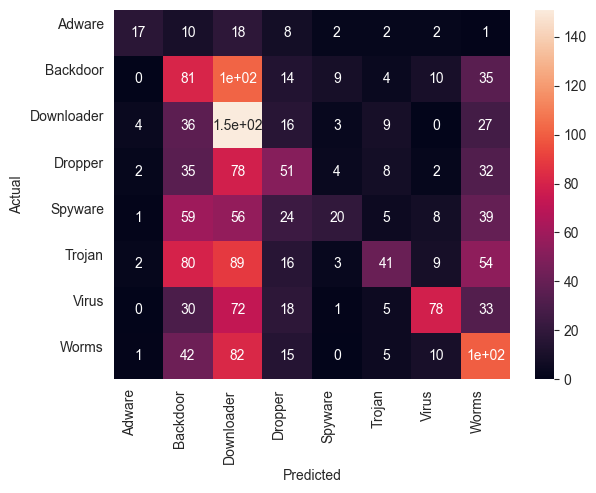

Training classifier:  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
F1 Score: 0.5110986325172726


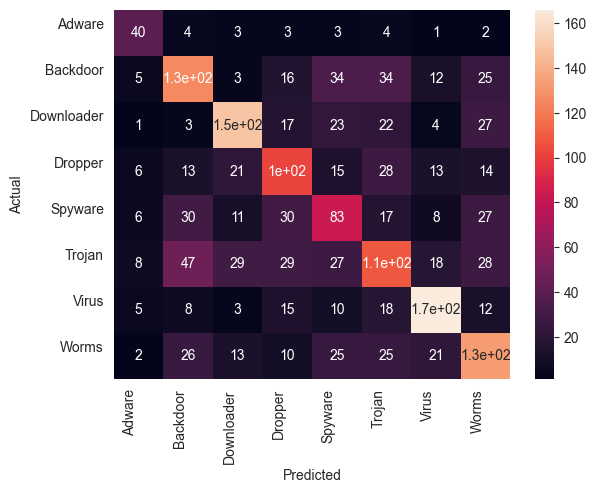

Training classifier:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
F1 Score: 0.6185066818287904


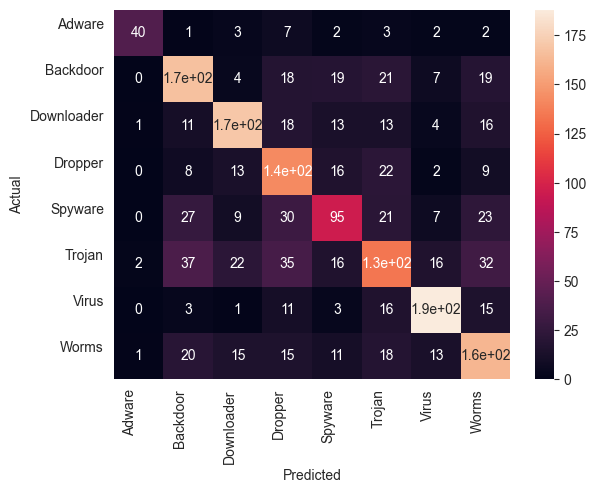

Training classifier:  <class 'sklearn.svm._classes.SVC'>
F1 Score: 0.30706335560623665


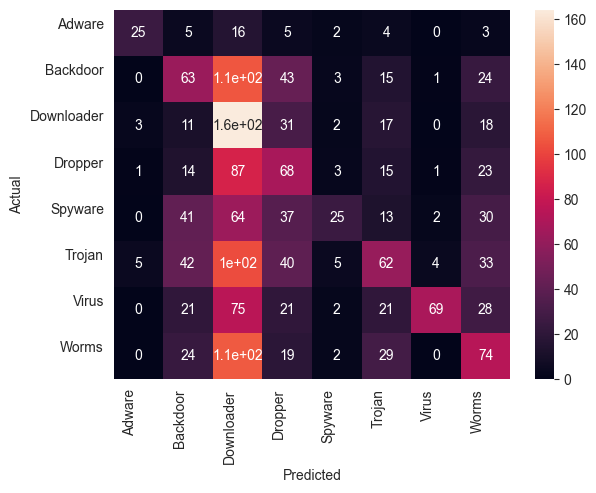

Training classifier:  <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
F1 Score: 0.5745520881963828


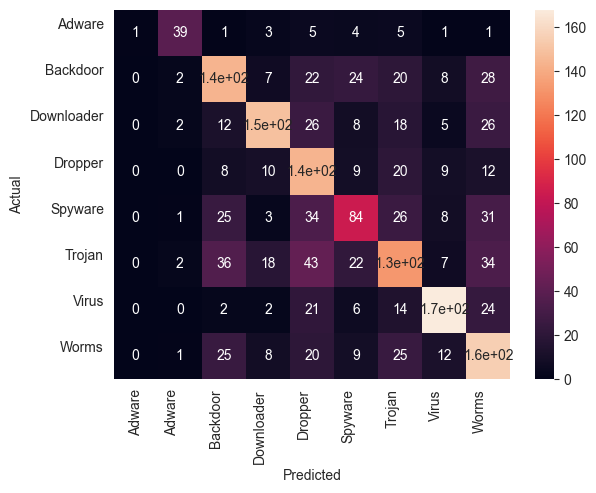

In [16]:
for classifier in classifiers:
    print('Training classifier: ', type(classifier))
    train_classifier(X_train, X_test, y_train, y_test, classifier = classifier)
    if type(classifier) is RandomForestClassifier:
        dump(classifier, './classifier.joblib')